In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src/py-tyssue/')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [3]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['cell', 'jv', 'je'])
sheet = Sheet('emin', datasets)





### Datasets are made of dataframes 

They are manipulated as such.

```python
hdf5.save_datasets('small_hexagonal.hf5', sheet)

sheet.je_df.head()
sheet.cell_df.describe()
```

### Dataset Specifications

All the parameters are stored in **specifications**, which are nested dictionnaries.

for example:



In [65]:
geom_spec = geom.get_default_geom_specs()

In [66]:
set_data_columns(sheet, geom_spec)
geom.update_all(sheet, coords=sheet.coords)
sheet.cell_df.describe()

,perimeter,z,x,is_alive,area,y,old_idx,basal_shift,height,vol,vol_elasticity,prefered_height,contractility,prefered_area,num_sides
count,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,5.600000e+01,56.000000,56,56.000000,56.000000,56,56,56.00,56,56
mean,10.654597,-3.370320e-16,-1.284687e-15,0.714286,9.163036,4.440892e-16,27.500000,4,0.651436,7.825535,1,24,0.04,10,6
std,4.003702,5.972802e+00,3.319195e+00,0.455842,5.159561,3.319195e+00,16.309506,0,0.069771,4.406435,0,0,0.00,0,0
min,4.380964,-8.253977e+00,-4.669287e+00,0.000000,1.078220,-4.669287e+00,0.000000,4,0.607705,0.920836,1,24,0.04,10,6
25%,4.380964,-6.603181e+00,-3.258140e+00,0.000000,1.078220,-3.258140e+00,13.750000,4,0.607705,0.920836,1,24,0.04,10,6
50%,13.164050,-2.590520e-16,-1.702342e-15,1.000000,12.396962,1.369275e-15,27.500000,4,0.607705,10.587414,1,24,0.04,10,6
75%,13.164050,6.603181e+00,3.258140e+00,1.000000,12.396962,3.258140e+00,41.250000,4,0.760764,10.587414,1,24,0.04,10,6
max,13.164050,8.253977e+00,4.669287e+00,1.000000,12.396962,4.669287e+00,55.000000,4,0.760764,10.587414,1,24,0.04,10,6


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [67]:
# adim_parameters = model.default_params.copy()
### Testing aspect-ratio parametrization

mod_specs = model.get_default_mod_specs()
mod_specs['cell']['aspect'] = (6., np.float)
dim_mod_specs = model.dimentionalize(mod_specs)
set_data_columns(sheet, dim_mod_specs)
sheet.grad_norm_factor = dim_mod_specs['settings']['grad_norm_factor']
sheet.nrj_norm_factor = dim_mod_specs['settings']['nrj_norm_factor']

isotropic_relax(sheet, **mod_specs)

In [68]:
sheet.nrj_norm_factor

57600.0

In [69]:
%pdb

Automatic pdb calling has been turned OFF


In [70]:
from scipy import optimize


https://en.wikipedia.org/w/index.php?title=Vector_calculus_identities&section=13#Vector_dot_product

In [71]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)

0.886592687387 0.897959183673


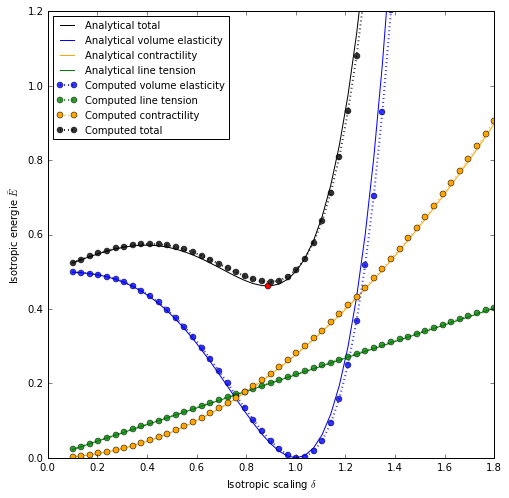

In [72]:
from tyssue.draw.mpl_draw import plot_analytical_to_numeric_comp

fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom,
                                          dim_mod_specs, mod_specs)


In [73]:
model.compute_energy(sheet) / sheet.cell_df.is_alive.sum()

0.46457789908092373

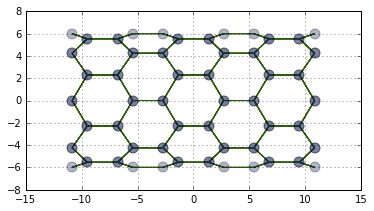

In [74]:
isotropic_relax(sheet)

fig, ax = sheet_view(sheet, ['z', 'x'])

[Des maths intéressantes pour ce qui nous occupe](http://lacim.uqam.ca/~bedard/notes/cours_MAT1110/MAT1110_ch10_v2005.pdf)

In [75]:
sheet.cell_df.describe().head(3)

,perimeter,z,x,is_alive,area,y,old_idx,basal_shift,height,vol,vol_elasticity,prefered_height,contractility,prefered_area,num_sides,prefered_vol,aspect,basal_height
count,56.000000,5.600000e+01,5.600000e+01,56.000000,56.00000,5.600000e+01,56.000000,5.600000e+01,56.000000,56.000000,56,56,56,56,56,56,56,5.600000e+01
mean,13.143443,-5.722935e-16,-1.570173e-15,0.714286,13.94388,5.075305e-16,27.500000,-2.878023e+00,0.651436,123.625422,1,10,96,24,6,240,6,-3.246161e+00
std,4.938941,7.368011e+00,4.094538e+00,0.455842,7.85158,4.094538e+00,16.309506,4.481082e-16,0.069771,69.611531,0,0,0,0,0,0,0,4.481082e-16


In [76]:
sheet.je_df.head()

,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,nx,ny,nz,sub_area,line_tension,sub_vol
srce,trgt,cell,,,,,,,,,,,,,
1,0,0,-2.291472,0.455802,-1.357607,2.702165,56,57,0,2.874114e+00,1.190497e+00,-1.044458,1.640785e+00,1410.906092,1.454708e+01
2,1,0,-1.942616,1.298014,1.357607,2.702165,57,58,0,-1.776357e-15,-1.165734e-15,0.000000,1.062353e-15,1410.906092,9.418748e-15
0,1,1,2.291472,-0.455802,1.357607,2.702165,56,57,1,6.221837e+00,8.250668e-01,0.696305,3.157405e+00,1410.906092,2.799332e+01
3,0,1,2.291472,0.455802,-1.357607,2.702165,56,59,1,6.221837e+00,-8.250668e-01,0.696305,3.157405e+00,1410.906092,2.799332e+01
1,6,1,0.000000,0.000000,2.715214,2.715214,57,62,1,6.221837e+00,4.125334e-01,0.000000,3.117749e+00,1410.906092,2.764173e+01


In [77]:
grad_i, grad_t, grad_c, grad_v = model.compute_gradient(sheet, components=True)

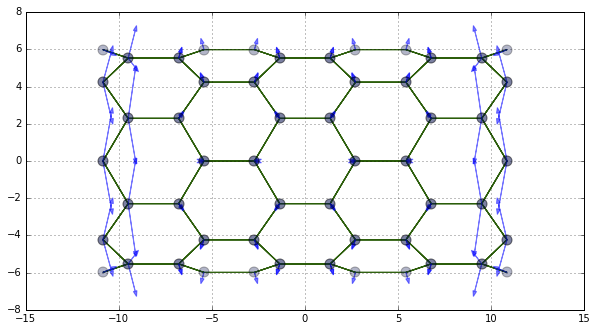

In [108]:

fig, ax = draw.plot_forces(sheet, model, ['z', 'y'], 20)
fig.set_size_inches(10, 12)


In [83]:
%pdb

Automatic pdb calling has been turned ON


http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [95]:

grad_err = solver.check_grad(sheet, sheet.coords)
grad_err /= sheet.cell_df.is_alive.sum()


print("Error on the gradient (non-dim, per cell): {:.3f}".format(grad_err))


Error on the gradient (non-dim, per cell): 0.050


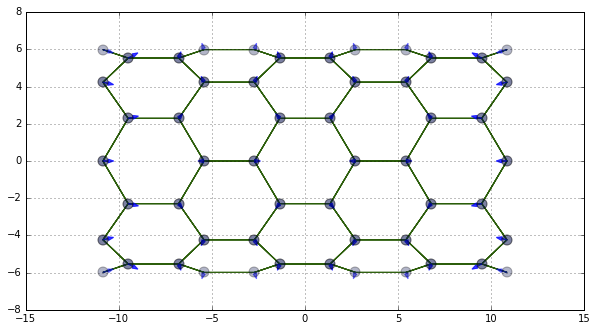

In [89]:
def draw_approx_force():
    fig, ax = draw.plot_forces(sheet, model,
                              ['z', 'y'], scaling=20,
                              approx_grad=solver.approx_grad)
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force()
#fig

In [34]:
grad_t.head()

,,,x,y,z
srce,trgt,cell,,,
1,0,0,-237.992103,1196.467099,708.859817
2,1,0,-677.744169,1014.315829,-708.859817
0,1,1,237.992103,-1196.467099,-708.859817
3,0,1,-237.992103,-1196.467099,708.859817
1,6,1,-0.000000,-0.000000,-1410.906092


In [49]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-1},
        'jac': solver.opt_grad
        }
    }

In [50]:

res = solver.find_energy_min(sheet, **settings)

In [51]:
res['success']

True

In [52]:
res['fun']

18.581432731680778

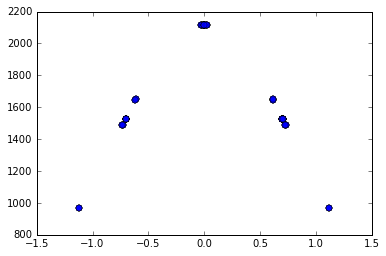

In [57]:
fig, ax = plt.subplots()
ax.plot(sheet.je_df.nz, sheet.je_df.line_tension, 'o', alpha=0.6)

In [54]:
sheet.je_df.line_tension = sheet.je_df.line_tension * (np.cos(sheet.je_df.nz)**2 + 0.5)

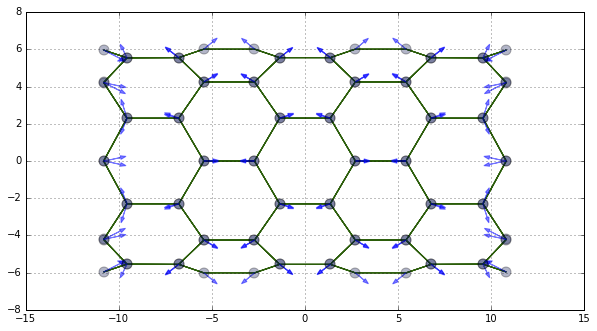

In [61]:
fig, ax = draw.plot_forces(sheet, model, ['z', 'y'], 10)
fig.set_size_inches(10, 12)


In [60]:
res = solver.find_energy_min(sheet, **settings)
print(res['success'])

True
